# Reference
- [辛普森 - Kaggle](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/)
- [辛普森 - ErhwenKuo中文](https://nbviewer.jupyter.org/github/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/2.2-simpson-characters-recognition.ipynb)
- A.Attia: [The Simpsons characters recognition and detection using Keras (Part 1)](https://medium.com/alex-attia-blog/the-simpsons-character-recognition-using-keras-d8e1796eae36)
- [WhereAmI - Kaggle](https://www.kaggle.com/c/aia-picture-classification1)
- [WhereAmI - Dataset](https://drive.google.com/drive/folders/1reO3wzToZuESza5xYU8qj5odkwEEad_J?usp=sharing)
- midterm_img_Keras.ipynb
    - 用到 packages: callbacks & generator
- 楊昌易/袁智暉: [where_am_i作業v4.ipynb](https://drive.google.com/open?id=16lKkXeXRG4YBCoiPW8HEYdGyugaaXpzY) (使用VGG16)


# 匯入相關所需的模組
- glob
    - [glob — Unix style pathname pattern expansion](https://docs.python.org/3/library/glob.html)
    - [簡單掌握Python中glob模塊查找文件路徑的用法](https://www.itread01.com/articles/1476166832.html)
- 進度條 [tqdm](https://pypi.org/project/tqdm/)
    - 程式前沿: [python的Tqdm模組的使用](https://codertw.com/程式語言/360929/)
- OpenCV (cv2)
    - cv2[.imread](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html)
        - G.T.Wang: [Python 與 OpenCV 基本讀取、顯示與儲存圖片教學](https://blog.gtwang.org/programming/opencv-basic-image-read-and-write-tutorial/)
    - cv2[.cvtcolor](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html)
        - 阿洲: [色彩空間轉換(cvtColor)](http://monkeycoding.com/?p=690)
    - cv2[.resize](https://docs.opencv.org/3.2.0/da/d6e/tutorial_py_geometric_transformations.html)
        - 阿洲: [影像尺寸改變(resize)](http://monkeycoding.com/?p=609)
- keras
    - 莫須 [keras](https://morvanzhou.github.io/tutorials/machine-learning/keras/)
        - [圖片分類](https://morvanzhou.github.io/tutorials/machine-learning/keras/2-2-classifier/)
        - keras[.Sequential](https://keras.io/models/sequential/)
    - keras.preprocessing.image[.ImageDataGenerator](https://keras.io/preprocessing/image/)
        - C.H.Tseng: [Data Augmentation 資料增強](https://chtseng.wordpress.com/2017/11/11/data-augmentation-資料增強/)


- collections (用不到)
    - [collections — Container datatypes](https://docs.python.org/3/library/collections.html)
    - [容器数据类型](https://docs.python.org/zh-cn/3/library/collections.html)
    - [不可不知的Python模块: collections](https://www.zlovezl.cn/articles/collections-in-python/)
- h5py (用不到)
    - [HDF5 for Python](http://docs.h5py.org/en/stable/)
    - [h5py 簡單操作 動態調整 dataset 大小](https://medium.com/@sean22492249/h5py-簡單操作-3af99e747c04)
- pickle(用不到)
    - [pickle — Python object serialization](https://docs.python.org/3/library/pickle.html)
    - 莫須: [pickle 保存数据](https://morvanzhou.github.io/tutorials/python-basic/basic/13-08-pickle/)

In [1]:
import os, glob, csv
# from random import shuffle
# from collections import Counter
# import h5py, pickle

#進度條
from tqdm import tqdm 
from time import sleep

import numpy as np
import pandas as pd #要讀取 'midterm_img.csv' & for confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam, RMSprop

# 顯示每一項 var.  的 output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Using TensorFlow backend.


# 設定路徑 & label var.

In [0]:
# 設定路徑
def set_paths(where):
    # 從 google drive
    if where == "google_drive":
        from google.colab import drive
        drive.mount('/content/gdrive')
        path_wrt = '/content/gdrive/My Drive/iiiTEXT/3_ML/HomeWork/HW20190106_WhereAmI_wrt'
        path_read = '/content/gdrive/My Drive/Datasets/Where Am I'
    
    # 從本機
    if where == 'local':
        path_wrt = '/Volumes/WD Book/GoogleDrive_iii/iiiTEXT/3_ML/HomeWork/HW20190106_WhereAmI_wrt'
        path_read = '/Volumes/WD Book/GoogleDrive_iii/Datasets/WhereAmI'
    
    # path_wrt, path_read = set_paths(where = 'local')
    os.chdir(path_wrt)
    # os.getcwd()
    # os.listdir()

    path_train = path_read + "/train"
    path_test = path_read + "/testset"
    map_file = path_read + "/midterm_img.csv"
    
    return path_wrt, path_train, path_test, map_file

In [0]:
# 卡通角色的Label-encoding
# map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
#         3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
#         7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
#         11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
#         14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

# Where Am I 的 label-encoding
map_places = {
    0: 'kitchen',
    1: 'street',
    2: 'industrial',
    3: 'insidecity',
    4: 'forest',
    5: 'livingroom',
    6: 'opencountry',
    7: 'PARoffice',
    8: 'mountain',
    9: 'CALsuburb',
    10: 'coast',
    11: 'store',
    12: 'bedroom',
    13: 'tallbuilding',
    14: 'highway',
}

num_classes = len(map_places) # 要辨識的角色種類 --> 修改為 map_places

# 函數
## 載入 Dataset

In [0]:
# 將訓練資料圖像從檔案系統中取出
def load_training_set(path, img_size, display=False, isColor=False):
    global map_places
    global num_classes
    pic_paths = []
    labels = []
    pic_count_sum = 0
    
    print("載入 Training Set")
    for k, v in map_places.items(): # k: 數字編碼 v: 角色label
        # 把某一個角色在檔案夾裡的所有圖像檔的路徑捉出來
        pic_count = 0
        for pic_path in glob.glob(path + "/" + v + "/*"):
            pic_paths.append(pic_path)
            labels.append(k)
            pic_count += 1
        
        # 顯示每個分類各有多少訓練圖像
        if display:
            print("(", k, ")\t", v + ": \t" + str(pic_count) + " pics")
        pic_count_sum += pic_count
    
    sleep(1)
    # resize & 轉為 np.array & normalize
    pics = normalized_pics(pic_paths, isColor, img_size)
    # 轉為 np.array & one-hot-encoding
    labels = np.array(labels)
    labels = keras.utils.to_categorical(labels, num_classes)
    
    # 顯示分類總數、所有圖像總數、 X&y 的維度
    if display:
        print("Training Set 一共" + str(len(map_places)) + "個分類 / " + str(pic_count_sum) + "張圖片",
                pics.shape,
                labels.shape)

    return np.array(pics), np.array(labels)

# 載入 test set
def load_test_set(img_path, map_file, img_size, n_classes, isColor, display=False):
    pic_paths, labels = [], []
    
    with open(map_file) as csvfile:
        rows = csv.reader(csvfile)
        for row in rows:
            if row[0] != 'id':
                pic_paths.append(img_path + "/" + row[0] + ".jpg")
                labels.append(row[1])

    pics = normalized_pics(pic_paths, isColor, img_size)
    sleep(0.2)
    labels = np.array(labels)
    labels = keras.utils.to_categorical(labels, n_classes) # 進行one-hot編碼
    print("Test set", pics.shape, labels.shape)
    return pics, labels

def normalized_pics(pic_path_array, isColor, img_size):
    # resize & 轉為 np.array & normalize
    pics=[]
    pbar = tqdm(total=len(pic_path_array)) 
    pbar.set_description("resizing & normalizing")
    pbar.clear
    
    for pic_path in pic_path_array:
        if isColor:
            tmp_img = cv2.imread(pic_path)
            # 由於OpenCv讀圖像時是以BGR , 要把它轉置成RGB
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
        else:
            #直接讀成灰階
            tmp_img = cv2.imread(pic_path, cv2.IMREAD_GRAYSCALE)
        
        # 統一圖片大小
        tmp_img = cv2.resize(tmp_img, img_size) 
        pics.append(tmp_img)
        pbar.update(1)
    
    # 轉為 np.array & normalize
    pics = np.array(pics).astype('float32')/255.
    if not isColor:
        # 灰階要升維
        pics = pics.reshape(pics.shape[0], img_size[0], img_size[1], 1)
    
    pbar.close() 
    
    return pics

## 定義模型

In [0]:
def cnn_Mcv_xN(n_classes, input_shape, filters,
                        dropout_mp0=0, dropout_mp1=0,
                        xMs=[1], padding1='same', padding_m='same', dropout_cv=0,
                        dropout_flt=0, BN_flt=False,
                        n_hdn=None, 
                        dropout_hdn=0, BN_hdn=False,
                        ):
    # 做 M 個 Conv2D
    # 執行 max pooling
    # dropout
    #       以上程序反覆 N次
    #       --> 也就是一共做了 MxN 次卷積層
    
    model = Sequential()
    if len(xMs) != len(filters):
        print("len(xMs)= len(filters)")
        return None
    xN = len(xMs)
    
    #卷積&池化層
    for n in range(0, xN):
        # 連續xM個卷積層
        if n == 0:
            model.add(Conv2D(filters[n], (3, 3), padding=padding1, activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(filters[n], (3, 3), padding=padding1, activation='relu'))

        if dropout_cv > 0:
                model.add(Dropout(dropout_cv))
        
        for m in range(1, xMs[n]):
            model.add(Conv2D(filters[n], (3, 3), padding=padding_m, activation='relu'))
            if dropout_cv > 0:
                model.add(Dropout(dropout_cv))

        if dropout_mp0 > 0:
                model.add(Dropout(dropout_mp0))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if dropout_mp1 > 0:
                model.add(Dropout(dropout_mp1))
    
    #平坦層
    model.add(Flatten())
    if dropout_flt >0:
        model.add(Dropout(dropout_flt))
    if BN_flt:
        model.add(BatchNormalization())
    
    #隱藏層
    if n_hdn==None:
        n_hdn = filters[-1]
    model.add(Dense(n_hdn, activation='relu'))
    if dropout_hdn >0:
        model.add(Dropout(dropout_hdn))
    if BN_hdn:
        model.add(BatchNormalization())
    
    #輸出層
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

def min_shape(xM, xN, padding):
    # 計算 Mcv xN 所需最小的 input_shape
    s = 1
    r = 0 if padding=='same' else 2
    for n in range(1, xN+1):
        s = 2*s #經過 max-pooling 後 shape 變一半
        s = s + r*(xM-1) #每次 Con2D 之後 shpae 會減2
    
    return s

def VGG16(img_shape, n_classes, n_hdn):
    from keras.applications import VGG16
    conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=img_shape)

    model = Sequential()
    model.add(conv_base)

    model.add(Flatten())
    model.add(BatchNormalization())
    
    model.add(Dense(n_hdn, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(n_classes, activation='softmax'))

    # “凍結”卷積基底
    conv_base.trainable = False
    
    return model


## 以 Training Set 訓練/驗證

In [0]:
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

def start_training(X, y, model, optimizer, save_filename, test_size, aug=False,
                         batch_size=32, epochs=1,
                         show_model_summary=False, show_train_history=False,
                         option_learning_rate='scheduler'):
    if show_model_summary:
        # 秀出模型架構
        model.summary()

    #定義訓練方式
    model.compile(loss='categorical_crossentropy',
                         optimizer=optimizer,
                         metrics=['accuracy'])
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=test_size)

    # 選擇 learning rate
    if option_learning_rate.lower()=='scheduler':
        lr_method = LearningRateScheduler(lr_schedule)
    elif option_learning_rate.lower()=='reduce':
        lr_method = ReduceLROnPlateau(monitor='val_acc', 
                                                        patience=3, 
                                                        verbose=1, 
                                                        factor=0.5, 
                                                        min_lr=0.00001)

    # 開始訓練
    if not aug:
        chkpoint = ModelCheckpoint(save_filename+".h5", save_best_only=True)     # 保留"val_acc"最好的那個模型
        history = model.fit(X_tr, y_tr,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  #validation_split = test_size,
                                  validation_data=(X_val, y_val),
                                  shuffle=True,
                                  callbacks=[lr_method, chkpoint],
                                  )
    
    # 使用圖像增強
    else:
        from keras.preprocessing.image import ImageDataGenerator
        dtgen = ImageDataGenerator(
                    featurewise_center=False,  # set input mean to 0 over the dataset
                    samplewise_center=False,  # set each sample mean to 0
                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
                    samplewise_std_normalization=False,  # divide each input by its std
                    zca_whitening=False,  # apply ZCA whitening
                    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                    horizontal_flip=True,  # randomly flip images
                    vertical_flip=False)  # randomly flip images
        dtgen.fit(X_tr)
        chkpoint = ModelCheckpoint(save_filename+".h5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        history = model.fit_generator(dtgen.flow(X_tr, y_tr, batch_size=batch_size),
                                                 steps_per_epoch=X_tr.shape[0] // batch_size,
                                                 epochs=epochs,
                                                 validation_data=(X_val, y_val),
                                                 callbacks=[lr_method, chkpoint],
                                                 )
    
    
    # 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plot_train_history(history, 'loss','val_loss')
    plt.subplot(1,2,2)
    plot_train_history(history, 'acc','val_acc')
    fig = plt.gcf()# gcf: Get Current Figure
    if show_train_history:
        plt.show();
    fig.savefig(save_filename+"_tr_history.png")

    return history


## 以 Testset 預測/驗證

In [0]:
def predict_with_testset(filename, X, y_true,
                                 show_clf_report=False,
                                 show_confusion_matrix=False,
                                 show_pic_sample=False):
    global map_places
    global num_classes
    # 預測與比對
    
    # 載入模型
    from keras.models import load_model
    print("載入", filename)
    model = load_model(filename)

    print("預測 Testset...", end="")
    y_pred = model.predict_classes(X)
    acc = np.sum(y_pred==np.argmax(y_true, axis=1))/np.size(y_pred)
    
    print("準確率accuracy =", acc)
    
    # 輸出各種圖表
    if show_clf_report:
        # 每一種 label 的預測正確率
        # 使用sklearn的分類報告來看預測結果
        from sklearn.metrics import classification_report
        print("\n",
        classification_report(np.where(y_true > 0)[1],  y_pred, 
                                     target_names=list(map_places.values())
        )
        )
    
    # 混淆矩陣可視化
    from sklearn.metrics import confusion_matrix
    # sns.set()
    classes = list(map_places.values())
    df = pd.DataFrame(confusion_matrix(np.where(y_true > 0)[1], y_pred), 
                                index=classes, columns=classes)

    plt.figure(figsize = (10,10))
    sns.heatmap(df, annot=True, square=True, fmt='.0f', cmap="Blues")
    plt.title('Truth/Prediction Confusion Matrix')
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.savefig(filename.replace(".h5","_cm.png"))
    if show_confusion_matrix:
        plt.show();
    
    # 隨機從 training set 取圖片, 並附註實際類別 vs 預測類別
    # https://github.com/alexattia/SimpsonRecognition/blob/master/Data%20Processing%20and%20Learning.ipynb
    from mpl_toolkits.axes_grid1 import AxesGrid
    F = plt.figure(1, (15,20))
    grid = AxesGrid(F, 111,  # similar to subplot(141)
                    nrows_ncols=(4, 4),
                    axes_pad=0,
                    label_mode="1")

    for i in range(0, num_classes):
        place = map_places[i]
        image = cv2.imread(np.random.choice([k for k in glob.glob(path_train + '/%s/*.jpg' % place) ]))
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pic = cv2.resize(image, (32,32)).astype('float32') / 255.
        a = model.predict(pic.reshape(1, 32,32,3))[0]
        actual = map_places[i]
    #     pred = map_characters[np.argmax(a)].split('_')[0].title()
        text = sorted(['{:s} : {:.1f}%'.format(map_places[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
                           key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
        img = cv2.resize(img, (352, 352))
        cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
        for k, t in enumerate(text):
            cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
    #     cv2.putText(img, 'Pred : %s' % pred, (100, 310), font, 0.7,(0,0,0),2,cv2.LINE_AA)    
        grid[i].imshow(img)

    plt.savefig(filename.replace(".h5","_train_pred.png"))
    if show_pic_sample:
        plt.show();
        
    return y_pred, acc

# 主程式 MAIN

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
載入 Training Set
( 0 )	 kitchen: 	110 pics
( 1 )	 street: 	192 pics
( 2 )	 industrial: 	211 pics
( 3 )	 insidecity: 	208 pics
( 4 )	 forest: 	228 pics
( 5 )	 livingroom: 	189 pics
( 6 )	 opencountry: 	310 pics
( 7 )	 PARoffice: 	115 pics
( 8 )	 mountain: 	274 pics
( 9 )	 CALsuburb: 	141 pics
( 10 )	 coast: 	260 pics
( 11 )	 store: 	215 pics
( 12 )	 bedroom: 	116 pics
( 13 )	 tallbuilding: 	256 pics
( 14 )	 highway: 	160 pics


resizing & normalizing: 100%|██████████| 2985/2985 [00:11<00:00, 260.32it/s]


Training Set 一共15個分類 / 2985張圖片 (2985, 32, 32, 3) (2985, 15)
檔名:  p32_vgg16_RMSprop_ep20_lr=reduce
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
Total params: 14,750,799
Trainable params: 3

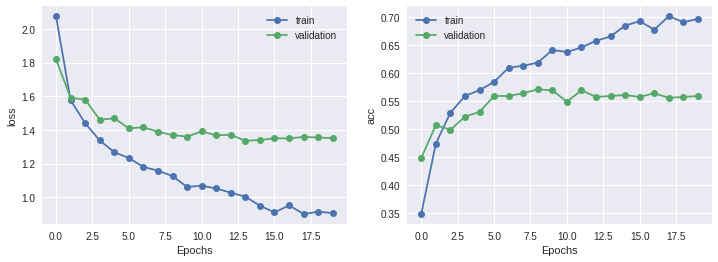

resizing & normalizing: 100%|██████████| 1500/1500 [00:06<00:00, 236.93it/s]


Test set (1500, 32, 32, 3) (1500, 15)
載入 p32_vgg16_RMSprop_ep20_lr=reduce.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


預測 Testset...準確率accuracy = 0.482

               precision    recall  f1-score   support

     kitchen       0.20      0.09      0.13        54
      street       0.50      0.64      0.56        88
  industrial       0.21      0.23      0.22        88
  insidecity       0.40      0.58      0.47       125
      forest       0.65      0.59      0.62       102
  livingroom       0.32      0.33      0.32       120
 opencountry       0.49      0.64      0.56       107
   PARoffice       0.41      0.33      0.36        73
    mountain       0.62      0.61      0.62       109
   CALsuburb       0.72      0.53      0.61       108
       coast       0.72      0.47      0.57       124
       store       0.33      0.53      0.41        91
     bedroom       0.49      0.28      0.36       103
tallbuilding       0.54      0.63      0.58       120
     highway       0.66      0.50      0.57        88

   micro avg       0.48      0.48      0.48      1500
   macro avg       0.48      0.46      0.46  

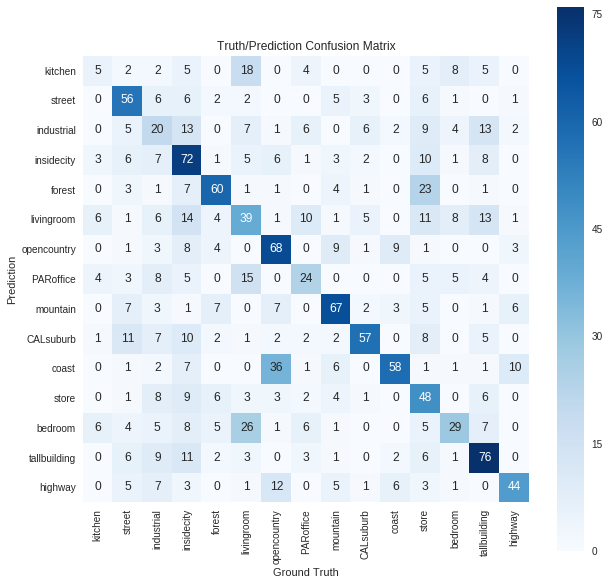

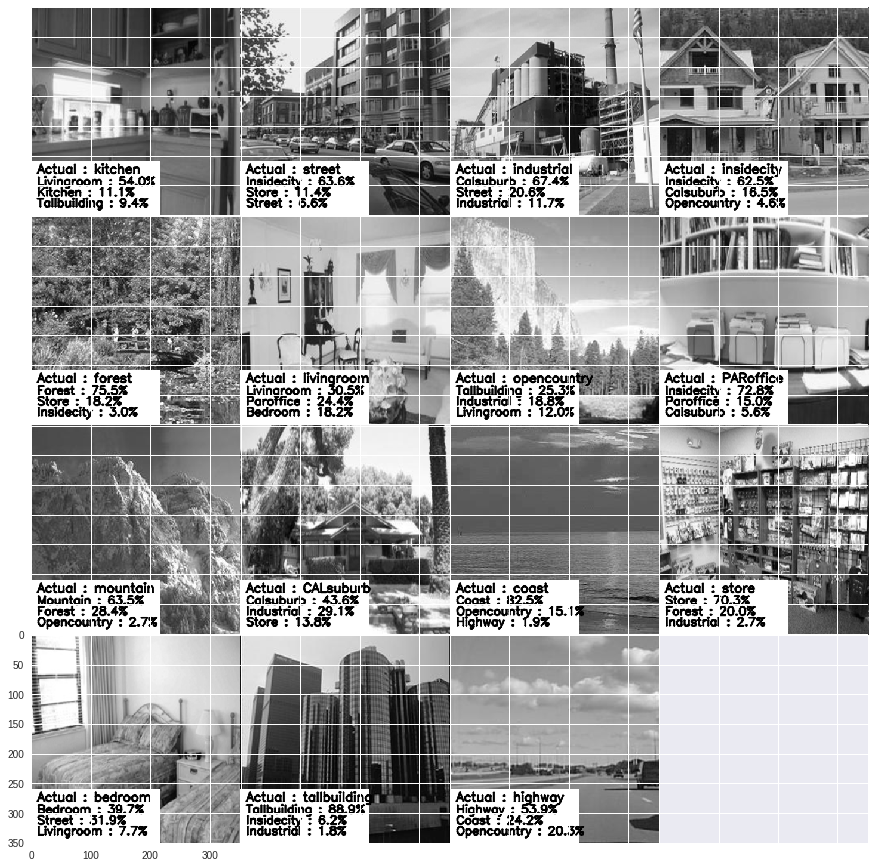

In [9]:
# 選擇資料來源 : 'local' or 'google_drive' 擇一
#  詳細路徑設定見 set_paths()
path_wrt, path_train, path_test, map_file = set_paths('google_drive')

img_wh = 32 #指定 input_shape
is_color = True # 指定是否直接讀成灰階; 若用 VGG 模型, 必須為 True
X_, y_ = load_training_set(path_train, img_size=(img_wh, img_wh), isColor=is_color, display=True)

# Optimizers 擇一
# optz = Adam()
# optz = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
optz = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
str_optz = str(optz)[str(optz).find("optimizers.")+len("optimizers.") : str(optz).find(" obj")]

# Learning Rate 擇一
# option_lr = 'scheduler'
option_lr = 'reduce'

epochs = 20
lr = 0.01     #指定初始 learning rate

# Model 擇一: 
choice = 1  # 0: 自定義 CNN model /  1: VGG16
if choice==0:
    # 模型選擇[0]: 自己定義 CNN model 
    m = (2,2)      #tuple; 指定每次 max-pooling 前要做幾次 Conv2D
    fltr = (32,64)   #tuple; 指定每次 Conv2D 的 filters 數量; 長度需與 m 一致
    model_self = cnn_Mcv_xN(xMs=m, filters=fltr,
                                           n_classes=num_classes,
                                           input_shape=X_[0,:,:,:].shape,
                                           #指定各層的 dropout ratio
                                           dropout_cv=0, dropout_mp0=0.25, dropout_mp1=0,
                                           dropout_flt=0, dropout_hdn=0,
                                           BN_flt=True, BN_hdn=True,  #指定是否在 flatten/hidden layer 後使用 Batch Normalization
                                           n_hdn=None,                      #hidden layer 層數; 若 n_hdn=None 則自動設定為最後一層的 filter 總數
                                           )
    best_model_filename = "p"+str(img_wh)+"_m"+str(m)+"_f"+str(fltr)+"_"+str_optz+"_ep"+str(epochs)+"_lr="+option_lr
    
elif choice==1:
    # 模型選擇[1]: 或是直接套用 VGG
    model_self = VGG16(img_shape=X_[0,:,:,:].shape,
                                 n_classes=num_classes,
                                 n_hdn=img_wh *2, #hidden layer 層數
                                 )
    best_model_filename = "p"+str(img_wh)+"_vgg16_"+str_optz+"_ep"+str(epochs)+"_lr="+option_lr

print("檔名: ", best_model_filename)    

# 開始訓練
history = start_training(X_, y_,
                                   test_size=0.2, aug=True,
                                   model = model_self,
                                   optimizer = optz,
                                   save_filename = best_model_filename,
                                   epochs=epochs,
                                   option_learning_rate=option_lr,
                                   show_model_summary=True,
                                   show_train_history=True,
                                   )

# 載入 testset
X_test, y_test = load_test_set(path_test, map_file, n_classes=num_classes,
                                         img_size=(img_wh, img_wh), isColor=is_color,
                                         display=True)
# 以 testset 預測/比對
y_pred, acc = predict_with_testset(best_model_filename +".h5", X_test, y_test,
                                                 show_clf_report=True,
                                                 show_confusion_matrix=True,
                                                 show_pic_sample=True)

new_filename = str(round(acc,3)) + "_" + best_model_filename
for file in glob.glob(best_model_filename+"*"):
    os.rename(file, file.replace(best_model_filename, new_filename))